In [1]:
import torch
import torch.nn.init as init
import torch.optim as optim
import torch.nn as nn
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt

In [2]:
data = loadmat('SampleCine.mat')['S']
data = data.astype(np.float32)

def get_loss(P):
    P = P.view(22500,25)
    U,S,V = torch.svd(P)
    loss = sum(S)
    return loss

def get_sparse_loss(L, T):
#     L = L.view(22500,25)
#     T = T.view(22500,25)
    return nn.L1Loss()

def get_UV_loss(P, T):
#     L = L.view(22500,25)
#     T = T.view(22500,25)
    T = T.view()
    U,V = P[:]

In [3]:
class LR_net(nn.Module):
    def __init__(self, n_in, n_out):
        super(LR_net, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(n_in, 64, (3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, (3, 3), stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 128, (3, 3), stride=1, padding=1)
        self.conv6 = nn.Conv2d(128, n_out, (3, 3), stride=1, padding=1)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
#         x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        return x
    
    def _initialize_weights(self):
        init.kaiming_normal_(self.conv1.weight)
        init.kaiming_normal_(self.conv2.weight)
        init.kaiming_normal_(self.conv3.weight)
        init.kaiming_normal_(self.conv4.weight)
#         init.kaiming_normal_(self.conv5.weight)
        init.kaiming_normal_(self.conv6.weight)

In [4]:
device = 'cuda'
model = LR_net(25,25).to(device)
criterion = get_sparse_loss
num_epoch = 100
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()
log_interval = 100

In [5]:
epoch_loss = 0
for epoch in range(1, num_epoch + 1):
    in_imgs = np.transpose(data,(2,0,1))
    in_imgs = np.expand_dims(in_imgs,0)
    in_imgs = torch.FloatTensor(in_imgs).to(device)
    out = model( in_imgs )
    #print(out.shape)
    loss = criterion(out, in_imgs)
    epoch_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % log_interval == 0:
        print('Epoch{} Loss: {}',epoch, epoch_loss/epoch)
mean_loss = epoch_loss / (num_epoch)
    

Epoch{} Loss: {} 100 36.55233060836792


In [6]:
L = out.detach().cpu().squeeze()
print(L.shape)
L = L.permute(1,2,0)
print(L.shape)
Y = in_imgs.detach().cpu().squeeze()
Y = Y.permute(1,2,0)
print(L.shape)

torch.Size([25, 150, 150])
torch.Size([150, 150, 25])
torch.Size([150, 150, 25])


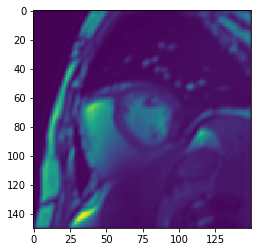

In [7]:
plt.imshow(L[:,:,7])

In [8]:
print(L.shape)

torch.Size([150, 150, 25])


In [9]:
L = L.numpy()
Y = Y.numpy()
savemat('LS_res.mat',{'L':L,'Y':Y})